In [63]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
#plt.rcParams["figure.figsize"] = (8,5)
import warnings
warnings.filterwarnings('ignore')

plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)


In [54]:
def for_plot(file,rcp):
    
    # read the input data
    df=pd.read_excel(file)
    df=df[df['Sea Surface Height Above Geoid (m)']!=1.000000020040877e+20].reset_index(drop=True) #remove outlier value
    df['date']=df['date'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')) # convert column value to datetime format
    df=df[(df['date']>=datetime(2006, 1, 1)) & (df['date']<=datetime(2100, 12, 31))].reset_index(drop=True) # subset data upto year-2100
    
    # calculate relative sea level change from sea surface height above geoid data
    for _, df_g in df.groupby(['model','projection','ensemble']):
        index=df_g.index
        idxmin=min(index)
        df.loc[index,'change']=df.loc[index,'Sea Surface Height Above Geoid (m)']-df.loc[idxmin,'Sea Surface Height Above Geoid (m)']
        
        
    # subset data based on projection ['RCP45','RCP85']
    df=df[df['projection']==rcp]
    df.reset_index(drop=True,inplace=True)
    
    # filter the data based on selected model given in the list
    model_list=['GISS-E2-R','HadGEM2-ES','MIROC-ESM-CHEM','NorESM1-M','NorESM1-ME']
    df=df.query('model in @model_list')

    # set date column as index of dataframe
    df.set_index('date',inplace=True)
    # create unique column "ID" by nmerging model, projection & ensemble for groupby operation
    df['ID']=df['model']+'_'+df['projection']+'_'+df['ensemble']
    # drop other columns except ['ID','change'] from dataframe
    df=df[['ID','change']]
    
    # resample data from monthly to yearly average 
    yearly_mean=df.groupby('ID').resample('1Y')['change'].mean().reset_index()
    pivot_df=yearly_mean.pivot(index='date',columns='ID',values='change') # pivot the dataframe to get ID as column
    col_name=pivot_df.columns.to_list() # list of columns name of pivoted dataframe
    
    # create a empty dataframe to save the percentile values
    plot_df=pd.DataFrame(index=np.arange(len(pivot_df)))
    
    # calculate [5, 50, 95] percentile value from all columns value
    plot_df.loc[:,'median']=pivot_df[col_name].apply(lambda x: np.nanpercentile(x,50),axis=1).to_list()
    plot_df.loc[:,'P_95']=pivot_df[col_name].apply(lambda x: np.nanpercentile(x,95),axis=1).to_list()
    plot_df.loc[:,'P_5']=pivot_df[col_name].apply(lambda x: np.nanpercentile(x,5),axis=1).to_list()
    plot_df.loc[:,'type_data']=rcp
    plot_df.loc[:,'Year']=np.arange(2006,2101)
    
    
    return plot_df

In [55]:
input_file='./Extracted Data/zos/Location5.xlsx'
rcp_list=['rcp45','rcp85']

df_rcp45=for_plot(input_file,rcp_list[0])
df_rcp85=for_plot(input_file,rcp_list[1])

In [56]:
new_df=pd.concat([df_rcp45, df_rcp85], ignore_index=True)

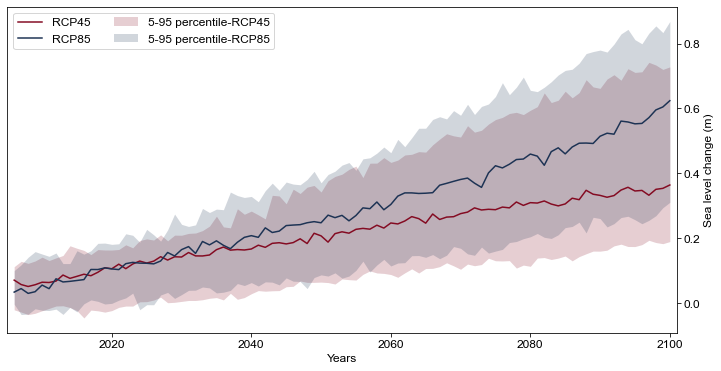

In [64]:
rcp45_col='#840B22'
rcp85_col='#1D3354'
color_palette=(rcp45_col,rcp85_col)
alpha=[0.2,0.2]
#plt.tick_params(axis='y', which='right', labelleft=False, labelright=True)
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

fig, ax = plt.subplots(1,1,figsize=(12,6))

label_01=['RCP45','RCP85']
label_02=['5-95 percentile-RCP45','5-95 percentile-RCP85']


for idx, rcp in enumerate(new_df.type_data.unique()):
    subset=new_df.loc[(new_df['type_data']==rcp)]
    ax.plot(subset.Year, subset['median'],label=label_01[idx], color=color_palette[idx])
    #ax.fill_between(subset.Year,subset.P_5, subset.P_95, alpha=0.2,label=rcp, linewidth=0.0, color=color_palette[idx])
    ax.fill_between(subset.Year,subset.P_5, subset.P_95, alpha=alpha[idx], label=label_02[idx], linewidth=0.0, color=color_palette[idx])

plt.legend(ncol=2,loc=2)
plt.xlim([2005,2101])
plt.xlabel('Years')
#plt.ylim([-0.02, 1.0])
ax.set_ylabel('Sea level change (m)')
ax.yaxis.set_label_position("right")
plt.savefig('Projection.jpg')